# NAR training pipeline for distilbert

In [1]:
#| default_exp 27-nar-training-pipeline-for-distilbert-prediction-with-tfidf-pruning

In [2]:
#| hide
from nbdev.showdoc import *
import nbdev; nbdev.nbdev_export()

In [3]:
%load_ext autoreload
%autoreload 2

In [9]:
#| export
import os, torch, torch.nn.functional as F, numpy as np, pickle
from tqdm.auto import tqdm
from xcai.basics import *
from xcai.models.MMM00X import DBT007

In [5]:
from xcai.transform import TriePruneInputIdsTfm
import matplotlib.pyplot as plt
set_plot_defaults()

In [6]:
os.environ['WANDB_MODE'] = 'disabled'

In [7]:
#| export
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

## Loading data and model

In [8]:
#| export
block = XCBlock.from_cfg('/home/aiscuser/scratch/datasets', 'data', valid_pct=0.001, tfm='xc', 
                         tokenizer='distilbert-base-uncased')

/opt/conda/envs/ptca/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/conda/envs/ptca/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [15]:
fname = '/home/aiscuser/outputs/20-nar-training-pipeline-for-distilbert/data/distilbert-base-uncased_block.pkl'
os.makedirs(os.path.dirname(fname), exist_ok=True)

with open(fname, 'wb') as file: pickle.dump(block, file)

In [155]:
fname = '/home/aiscuser/outputs/20-nar-training-pipeline-for-distilbert/data/distilbert-base-uncased_block.pkl'
with open(fname, 'rb') as file: block = pickle.load(file)

In [18]:
#| export
args = XCLearningArguments(
    output_dir='/home/aiscuser/outputs/20-nar-training-pipeline-for-distilbert',
    logging_first_step=True,
    per_device_train_batch_size=800,
    per_device_eval_batch_size=800,
    representation_num_beams=200,
    representation_accumulation_steps=100,
    save_strategy="steps",
    evaluation_strategy='steps',
    eval_steps=500,
    save_steps=500,
    save_total_limit=5,
    num_train_epochs=50,
    adam_epsilon=1e-6,
    warmup_steps=100,
    weight_decay=0.1,
    learning_rate=2e-4,
    generation_num_beams=10,
    generation_length_penalty=1.5,
    predict_with_generation=True,
    label_names=['lbl2data_idx'],
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [19]:
#| export
test_dset = block.test.dset.sample(n=2000, seed=50)
metric = PrecRecl(block.n_lbl, test_dset.data.data_lbl_filterer, prop=block.train.dset.data.data_lbl,
                  pk=10, rk=200, rep_pk=[1, 3, 5, 10], rep_rk=[10, 100, 200])

In [20]:
#| export
mname = f'{args.output_dir}/checkpoint-21500/'
model = DBT007.from_pretrained(mname, tn_targ=10_000, ig_tok=0, reduction='mean')


In [211]:
#| export
trie = XCTrie.from_block(block)

  0%|          | 0/312330 [00:00<?, ?it/s]

In [22]:
#| export
learn = XCLearner(
    model=model, 
    args=args,
    trie=trie,
    train_dataset=block.train.dset,
    eval_dataset=test_dset,
    data_collator=block.collator,
    compute_metrics=metric,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [23]:
o = learn.predict(test_dset)

/opt/conda/envs/ptca/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [24]:
display_metric(o.metrics)

,P@1,P@3,P@5,P@10,N@1,N@3,N@5,N@10,PSP@1,PSP@3,PSP@5,PSP@10,PSN@1,PSN@3,PSN@5,PSN@10,R@10,R@100,R@200,loss,runtime,samples_per_second,steps_per_second
0,14.6,9.45,7.3,4.56,14.6,14.2452,14.9516,15.9568,9.4955,9.9032,11.0339,12.519,9.4955,10.338,11.3063,12.237,18.8906,18.9579,18.9579,4.4093,120.1633,16.644,0.025


## Inference with `tf-idf` pruning

### Helper

In [143]:
from typing import Optional, List
from scipy import sparse

In [144]:
def compute_tok_tfidf(toks:Optional[List], n_cols:Optional[int]=None):
    tok_sparse = get_tok_sparse(toks, n_cols=n_cols)
    tok_idf = torch.tensor(tok_sparse.getnnz(axis=0))
    tok_idf = torch.log((tok_sparse.shape[0]+1)/(tok_idf+1)) + 1
    return tok_sparse.multiply(tok_idf.numpy())

def display_token_stats(x:sparse.csr_matrix, min_val:Optional[float]=None, max_val:Optional[float]=None):
    plt.figure(figsize=(7,5))
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    
    if min_val is None and max_val is None: idx = np.arange(len(x.data))
    elif min_val is None: idx = np.where(x.data < max_val)
    elif max_val is None: idx = np.where(x.data > min_val)
    else: idx = np.where(np.logical_and(x.data > min_val, x.data < max_val))
    
    o = ax[0].hist(x.data[idx], bins=100)
    ax[0].set_xlabel(r'$metric$'); ax[0].set_ylabel(r'$frequency$')
    ax[1].boxplot(x.data); ax[1].set_ylabel(r'$metric$')
    plt.show()
    
def sparse_threshold_mask(m, min_val:int, max_val:Optional[int]=None):
    v_m = m > min_val
    if max_val is not None:
        r,c = (m > max_val).nonzero()
        v_m[r,c] = 0
        v_m.eliminate_zeros()
    return v_m


In [134]:
test_dset = block.test.dset.sample(n=2000, seed=50)
metric = PrecRecl(block.n_lbl, test_dset.data.data_lbl_filterer, prop=block.train.dset.data.data_lbl,
                  pk=10, rk=200, rep_pk=[1, 3, 5, 10], rep_rk=[10, 100, 200])

### Label token pruning

#### `tf-idf`

In [135]:
lbl_tok_tfidf = compute_tok_tfidf(block.train.dset.data.lbl_info['input_ids'], n_cols=model.config.vocab_size)

<Figure size 700x500 with 0 Axes>

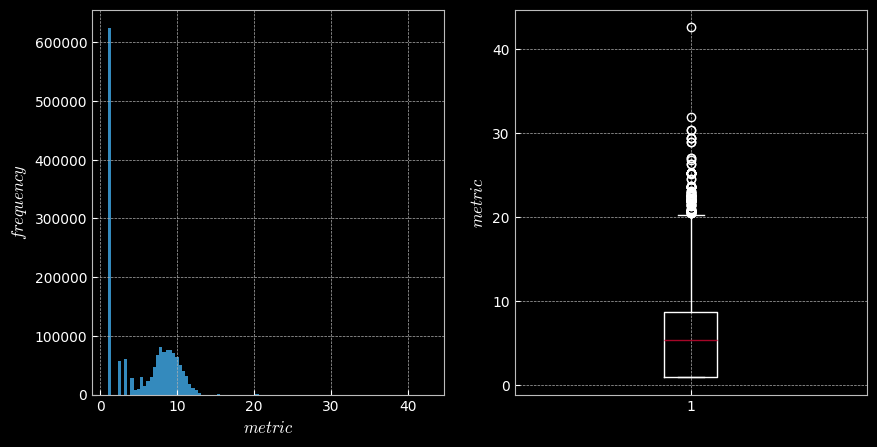

In [136]:
display_token_stats(lbl_tok_tfidf)

In [137]:
valid_toks = sparse_threshold_mask(lbl_tok_tfidf, 2, 20)
valid_toks[:, 101] = valid_toks[:, 102] = 1

/opt/conda/envs/ptca/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [43]:
lbl_input_ids = block.train.dset.lbl_info['input_ids']
lbl_toks = [[t for t in toks if valid_toks[i,t]] for i,toks in tqdm(enumerate(lbl_input_ids), total=len(lbl_input_ids))]
lbl_info = [[i] for i in range(len(lbl_toks))]

  0%|          | 0/312330 [00:00<?, ?it/s]

In [44]:
trie = Trie.from_list(lbl_toks, lbl_info)

  0%|          | 0/312330 [00:00<?, ?it/s]

In [241]:
#| export
learn = XCLearner(
    model=model, 
    args=args,
    trie=trie,
    train_dataset=block.train.dset,
    eval_dataset=test_dset,
    data_collator=block.collator,
    compute_metrics=metric,
)

In [46]:
o = learn.predict(test_dset)

In [47]:
display_metric(o.metrics)

,P@1,P@3,P@5,P@10,N@1,N@3,N@5,N@10,PSP@1,PSP@3,PSP@5,PSP@10,PSN@1,PSN@3,PSN@5,PSN@10,R@10,R@100,R@200,loss,runtime,samples_per_second,steps_per_second
0,14.65,9.5,7.29,4.54,14.65,14.3032,14.9669,15.9476,9.5401,9.9268,11.0157,12.4596,9.5401,10.3685,11.318,12.2291,18.8138,18.8841,18.8841,4.4093,124.9635,16.005,0.024


#### `idf`

In [140]:
lbl_tok_sparse = get_tok_sparse(block.train.dset.data.lbl_info['input_ids'], n_cols=model.config.vocab_size)
lbl_tok_idf = np.log((lbl_tok_sparse.shape[0]+1)/(lbl_tok_sparse.getnnz(axis=0)+1))+1

<Figure size 700x500 with 0 Axes>

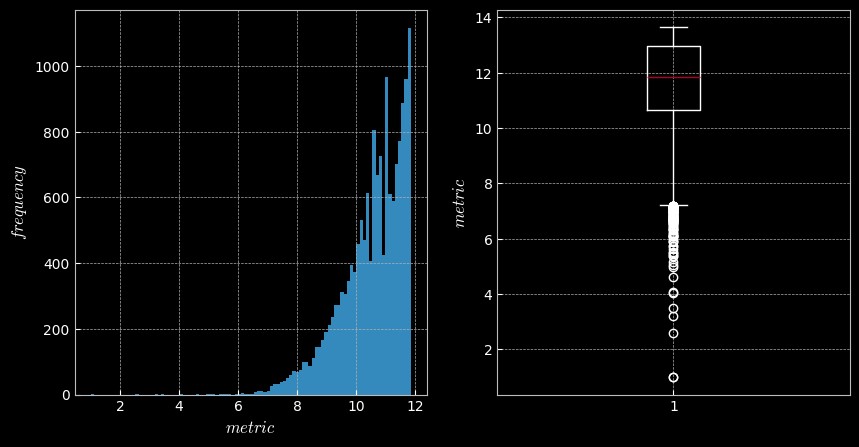

In [183]:
display_token_stats(sparse.csr_matrix(lbl_tok_idf), 0, 12)

In [184]:
valid_toks = np.logical_and(lbl_tok_idf > 4, lbl_tok_idf < 12)
valid_toks[101] = valid_toks[102] = 1

In [185]:
lbl_input_ids = block.train.dset.lbl_info['input_ids']
lbl_toks = [[t for t in toks if valid_toks[t]] for toks in tqdm(lbl_input_ids, total=len(lbl_input_ids))]
lbl_info = [[i] for i in range(len(lbl_toks))]

  0%|          | 0/312330 [00:00<?, ?it/s]

In [186]:
trie = Trie.from_list(lbl_toks, lbl_info)

  0%|          | 0/312330 [00:00<?, ?it/s]

In [187]:
learn = XCLearner(
    model=model, 
    args=args,
    trie=trie,
    train_dataset=block.train.dset,
    eval_dataset=test_dset,
    data_collator=block.collator,
    compute_metrics=metric,
)

In [188]:
o = learn.predict(test_dset)

/opt/conda/envs/ptca/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [189]:
display_metric(o.metrics)

,P@1,P@3,P@5,P@10,N@1,N@3,N@5,N@10,PSP@1,PSP@3,PSP@5,PSP@10,PSN@1,PSN@3,PSN@5,PSN@10,R@10,R@100,R@200,loss,runtime,samples_per_second,steps_per_second
0,11.2,7.6167,5.93,3.775,11.2,10.6053,11.0807,11.8745,8.5325,9.0766,10.0386,11.5378,8.5325,8.8794,9.6252,10.4502,14.294,14.8946,14.8946,4.16,100.0913,19.982,0.03


### Input token pruning

#### `tfidf`

In [212]:
data_tok_sparse = get_tok_sparse(block.train.dset.data.data_info['input_ids'], n_cols=model.config.vocab_size)
data_tok_idf = np.log((data_tok_sparse.shape[0]+1)/(data_tok_sparse.getnnz(axis=0)+1))+1

In [213]:
test_tok_sparse = get_tok_sparse(test_dset.data.data_info['input_ids'], n_cols=model.config.vocab_size)
test_tok_tfidf = test_tok_sparse.multiply(data_tok_idf)

<Figure size 700x500 with 0 Axes>

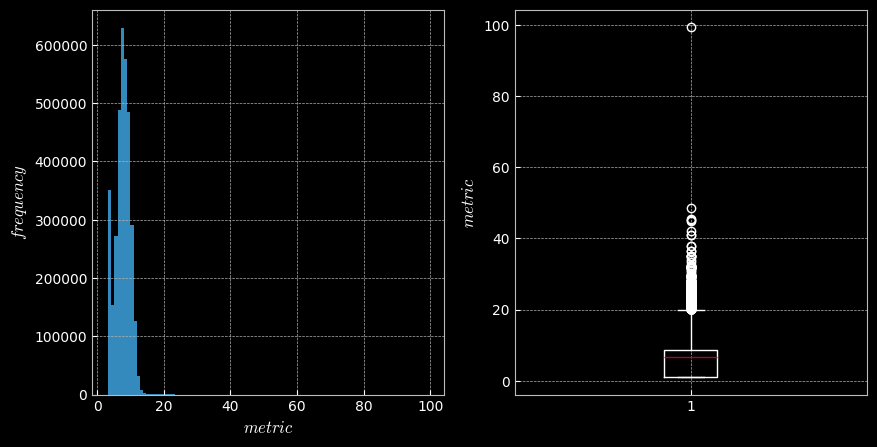

In [214]:
display_token_stats(data_tok_tfidf, 2)

In [215]:
valid_toks = sparse_threshold_mask(test_tok_tfidf, 4, 20)
valid_toks[:, 101] = valid_toks[:, 102] = 1

/opt/conda/envs/ptca/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [216]:
test_dset = block.test.dset.sample(n=2000, seed=50)
metric = PrecRecl(block.n_lbl, test_dset.data.data_lbl_filterer, prop=block.train.dset.data.data_lbl,
                  pk=10, rk=200, rep_pk=[1, 3, 5, 10], rep_rk=[10, 100, 200])

In [217]:
test_input_ids = test_dset.data.data_info['input_ids']
test_toks = [[t for t in toks if valid_toks[i,t]] for i,toks in tqdm(enumerate(test_input_ids), total=len(test_input_ids))]

test_attention_mask = test_dset.data.data_info['attention_mask']
test_mask = [p[:len(q)] for p,q in zip(test_attention_mask,test_toks)]


  0%|          | 0/2000 [00:00<?, ?it/s]

In [218]:
test_dset.data.data_info['input_ids'] = test_toks
test_dset.data.data_info['attention_mask'] = test_mask

In [219]:
o = learn.predict(test_dset)

In [220]:
display_metric(o.metrics)

,P@1,P@3,P@5,P@10,N@1,N@3,N@5,N@10,PSP@1,PSP@3,PSP@5,PSP@10,PSN@1,PSN@3,PSN@5,PSN@10,R@10,R@100,R@200,loss,runtime,samples_per_second,steps_per_second
0,11.15,7.15,5.72,3.63,11.15,10.125,10.7174,11.4556,8.3547,8.398,9.5529,11.1082,8.3547,8.3778,9.2087,10.065,13.8329,14.4893,14.4893,4.4377,69.1071,28.941,0.043


#### `idf`

In [221]:
data_tok_sparse = get_tok_sparse(block.train.dset.data.data_info['input_ids'], n_cols=model.config.vocab_size)
data_tok_idf = np.log((data_tok_sparse.shape[0]+1)/(data_tok_sparse.getnnz(axis=0)+1))+1

<Figure size 700x500 with 0 Axes>

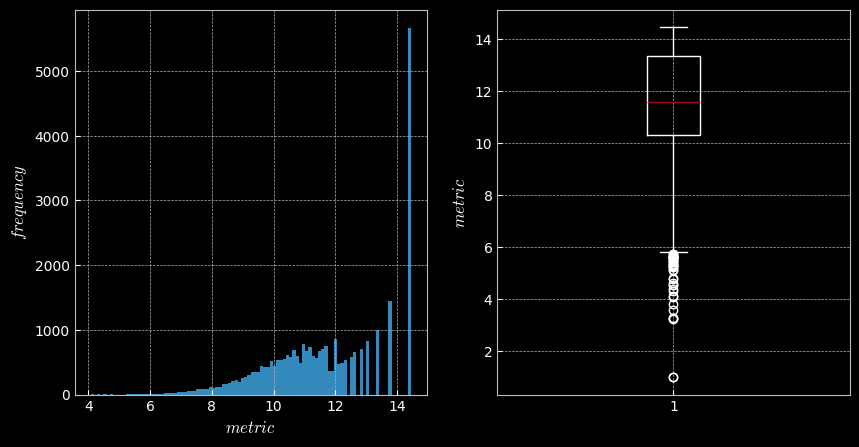

In [229]:
display_token_stats(sparse.csr_matrix(data_tok_idf), 4, 20)

In [258]:
valid_toks = np.logical_and(data_tok_idf > 2, data_tok_idf < 12)
valid_toks[101] = valid_toks[102] = 1

In [259]:
test_dset = block.test.dset.sample(n=2000, seed=50)
metric = PrecRecl(block.n_lbl, test_dset.data.data_lbl_filterer, prop=block.train.dset.data.data_lbl,
                  pk=10, rk=200, rep_pk=[1, 3, 5, 10], rep_rk=[10, 100, 200])

In [260]:
test_input_ids = test_dset.data.data_info['input_ids']
test_toks = [[t for t in toks if valid_toks[t]] for toks in tqdm(test_input_ids, total=len(test_input_ids))]

test_attention_mask = test_dset.data.data_info['attention_mask']
test_mask = [p[:len(q)] for p,q in zip(test_attention_mask,test_toks)]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [261]:
test_dset.data.data_info['input_ids'] = test_toks
test_dset.data.data_info['attention_mask'] = test_mask

In [262]:
o = learn.predict(test_dset)

/opt/conda/envs/ptca/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [263]:
display_metric(o.metrics)

,P@1,P@3,P@5,P@10,N@1,N@3,N@5,N@10,PSP@1,PSP@3,PSP@5,PSP@10,PSN@1,PSN@3,PSN@5,PSN@10,R@10,R@100,R@200,loss,runtime,samples_per_second,steps_per_second
0,14.15,9.1667,7.09,4.43,14.15,13.8568,14.5805,15.5682,9.0567,9.4899,10.5785,12.0207,9.0567,9.9287,10.9006,11.8059,18.5194,18.6034,18.6034,4.3845,106.7983,18.727,0.028


## Inference with `trie` pruning

In [119]:
block = TriePruneInputIdsTfm.apply(block, 'train.dset.data.lbl_info')
block = TriePruneInputIdsTfm.apply(block, 'test.dset.data.lbl_info')

  0%|          | 0/312330 [00:00<?, ?it/s]

  0%|          | 0/312330 [00:00<?, ?it/s]

In [123]:
block.train.dset.data.lbl_info['input_ids'] = block.train.dset.data.lbl_info['input_ids_prn_tre']
block.train.dset.data.lbl_info['attention_mask'] = block.train.dset.data.lbl_info['attention_mask_prn_tre']

block.test.dset.data.lbl_info['input_ids'] = block.test.dset.data.lbl_info['input_ids_prn_tre']
block.test.dset.data.lbl_info['attention_mask'] = block.test.dset.data.lbl_info['attention_mask_prn_tre']

In [124]:
trie = XCTrie.from_block(block)

  0%|          | 0/312330 [00:00<?, ?it/s]

In [125]:
test_dset = block.test.dset.sample(n=2000, seed=50)
metric = PrecRecl(block.n_lbl, test_dset.data.data_lbl_filterer, prop=block.train.dset.data.data_lbl,
                  pk=10, rk=200, rep_pk=[1, 3, 5, 10], rep_rk=[10, 100, 200])

In [126]:
learn = XCLearner(
    model=model, 
    args=args,
    trie=trie,
    train_dataset=block.train.dset,
    eval_dataset=test_dset,
    data_collator=block.collator,
    compute_metrics=metric,
)

In [127]:
o = learn.predict(test_dset)

/opt/conda/envs/ptca/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [128]:
display_metric(o.metrics)

,P@1,P@3,P@5,P@10,N@1,N@3,N@5,N@10,PSP@1,PSP@3,PSP@5,PSP@10,PSN@1,PSN@3,PSN@5,PSN@10,R@10,R@100,R@200,loss,runtime,samples_per_second,steps_per_second
0,15.6,9.8333,7.34,4.705,15.6,14.8807,15.375,16.4857,10.2486,10.4222,11.1889,13.1563,10.2486,10.8805,11.6432,12.7617,19.1571,19.1982,19.1982,4.16,129.1414,15.487,0.023
